In [1]:
import os, io
import numpy as np
import pandas as pd
from connections import AWS
import xml.etree.ElementTree as ET
from biomech.algorithms import NewtonEuler, diff_three_point, butter_lowpass_filter

In [2]:
""" CREATE AWS CONNECTION """
aws_connection = AWS()
aws_connection.connect()

[AWS]: Port 5433 is free.
[AWS]: Connected to RDS endpoint.


$\textbf{Biomech: Newton Euler Algorithm (Development)}$

Testing refined implementation of the Newton Euler algorithm following OpenSim modifications.

In [3]:
from biomech.opensim import load_osim_model

In [4]:
# update scaling tool XML for subject
    # subject_id: subject to scale (info loaded from json)
def update_model_hand_segment(
    tree: ET.ElementTree,
    throwing_hand: str,
    ball_mass: float = 0.145,                                       # mass of ball
    ball_radius: float = 0.0368,                                    # radius of ball
) -> None:

    root = tree.getroot()

    # find the hand body
    match throwing_hand:
        case 'left':
            hand_body = root.find(".//Body[@name='hand_l']")
        case 'right':
            hand_body = root.find(".//Body[@name='hand_r']")
    
    # update mass (+= 0.145)
        # combined center of mass computed with mass weighted avg of two bodies
    hand_mass = hand_body.find(".//mass")
    hand_mass.text = str(float(hand_mass.text) + ball_mass)
    
    # update mass center using mass wtd avgs
    com_new = compute_combined_com(float(hand_mass.text), ball_mass)
    hand_com = hand_body.find(".//mass_center")
    hand_com.text = ' '.join(map(str, com_new)) 

    # update inertia tensor as hand-ball segment
        # uses updated mass, mass center
        # tensor computed using parallel axis theorem
    I_new = compute_combined_inertia(float(hand_mass.text), com_new, m_ball=ball_mass, r_ball=ball_radius)
    hand_inertia = hand_body.find(".//inertia")
    hand_inertia.text = ' '.join(map(str, [I_new[0, 0], I_new[1, 1], I_new[2, 2], 0, 0, 0]))

    return tree

# compute combined CoM using mass wtd avgs
def compute_combined_com(
        m_hand: float,
        m_ball: float = 0.145           # mass of regulation ball in kg
) -> np.ndarray:

    # center of mass
    com_hand = np.array([0, -0.068095, 0])  
    com_ball = np.array([0.0368, -0.068095, 0])                                     # ball CoM shifted in x-direction
    com_new = (m_hand * com_hand + m_ball * com_ball) / (m_hand + m_ball)           # combined CoM

    return com_new

# compute combined inertia tensor using parallel axis theorem
def compute_combined_inertia(
        m_hand: float,
        com_combined: np.ndarray,
        com_hand: np.ndarray = np.array([0, -0.068095, 0]),
        com_ball: np.ndarray = np.array([0.0368, -0.068095, 0]),                    # ball CoM in hand frame shifted in x-direction by radius of ball
        m_ball: float = 0.145,                                                      # mass of regulation ball in kg
        r_ball: float = 0.0368,                                                     # radius of regulation ball in m
):
    # compute updated axes
    com_hand_prime = com_hand - com_combined
    com_ball_prime = com_ball - com_combined

    # inertia tensors (original; hand from rajagopal model)
    I_hand = np.diag([0.00093985399999999995, 
                    0.00057634600000000004, 
                    0.0014118900000000001])
    I_ball = 2/5 * m_ball * r_ball**2 * np.eye(3)  # ball inertia tensor; uniform density sphere

    # update inertia tensors through new axes -- parallel axis theorem
    I_hand_prime = I_hand + m_hand * (skew(com_hand_prime) @ skew(com_hand_prime))
    I_ball_prime = I_ball + m_ball * (skew(com_ball_prime) @ skew(com_ball_prime))

    # combined inertia tensor
    I_new = I_hand_prime + I_ball_prime

    return I_new

# create a skew symmetric matrix from a vector
def skew(vector: np.ndarray) -> np.ndarray:
    if len(vector) != 3:
        raise ValueError("Input vector must have exactly 3 elements.")

    return np.array([
        [0, -vector[2], vector[1]],
        [vector[2], 0, -vector[0]],
        [-vector[1], vector[0], 0]
        ])

In [5]:
# load all subject info
all_subject_info = aws_connection.load_subject_info()

# get all .mot files, osim models
s3_objects_all = aws_connection.list_s3_objects(prefix='subjects/')
s3_mot_files = [obj for obj in s3_objects_all if obj.endswith('.mot')]
s3_osim_models = [obj for obj in s3_objects_all if obj.endswith('.osim') and '_scaled' in obj]

In [19]:
s3_mot_files[18:19]

['subjects/2609/mot_processed/2609_22_ik.mot']

In [ ]:
# iterate through .mot files
for f in s3_mot_files[18:19]:

    # get subject ID & info from file name
    subject_id = f.split('/')[1]
    subject_info = all_subject_info[all_subject_info['subject_id'] == int(subject_id)]

    # open subject model XML from S3 --> write to local file
    subject_model_path = [obj for obj in s3_osim_models if subject_id in obj][0]
    subject_model_xml = aws_connection.load_xml_from_s3(subject_model_path)
    subject_model_tree = ET.ElementTree(subject_model_xml)

    # update hand ball segment properties
    subject_model_tree_updated = update_model_hand_segment(
        subject_model_tree,
        throwing_hand=subject_info['throws'].values[0]
    )

    # write & load model
    subject_model_tree_updated.write(f'opensim_models/trial_model.osim')
    subject_model = load_osim_model(f'opensim_models/trial_model.osim')
    
    # get trial joint angles (q)
    q_bytes = aws_connection.load_s3_object(f, return_info=False)
    q = pd.read_csv(io.BytesIO(q_bytes), delim_whitespace=True, skiprows=10)

    # convert angles to radians 
        # NOTE: don't apply to translational coords
    non_angle_cols = ['time', 'humerus_r_tx', 'humerus_r_ty', 'humerus_r_tz']
    q.loc[:, ~q.columns.isin(non_angle_cols)] = np.deg2rad(q.loc[:, ~q.columns.isin(non_angle_cols)])

    # apply filter, then get joint velocities (q_dot)
    q_filt = butter_lowpass_filter(
        q, 
        [col for col in q.columns if col not in non_angle_cols], 
        cutoff=18, 
        fs=480, 
        order=2
    )
    q_dot = diff_three_point(q_filt.iloc[:, 1:])

    # set up ID module and run
    id = NewtonEuler(subject_model, subject_info['throws'].values[0], q, q_dot, top_down=True)
    id.run()

    break

    # get elbow moments & rotation matrix
        # TODO: this needs to be throwing arm specific
    match subject_info['throws'].values[0]:
        case 'left':
            elbow_side = 'elbow_l'
        case 'right':
            elbow_side = 'elbow_r'
    pitch_elbow_moments = id.motion['joint'][elbow_side]['intersegmental_moment'].T
    pitch_Rj = id.motion['joint'][elbow_side]['rotation']
    
    # rotate at each time point
    num_samples = pitch_elbow_moments.shape[0]
    pitch_rotated_moments = np.zeros((num_samples, 3))            # initialize rotated array
    for t in range(num_samples):
        pitch_rotated_moments[t, :] = (pitch_Rj[:, :, t].T @ pitch_elbow_moments[t, :])

    # create dataframe
    pitch_elbow_moments_df = pd.DataFrame(
        pitch_rotated_moments, 
        columns=['elbow_moment_x', 'elbow_moment_y', 'elbow_moment_z']
    )
    pitch_elbow_moments_df.insert(0, 'time', q['time'])                                 # add time column
    pitch_elbow_moments_df.insert(0, 'study_id', f.split('/')[-1].split('_ik')[0])      # add study ID column


[info] Loaded model models_arm_right_scaled from file opensim_models/trial_model.osim


<Axes: >

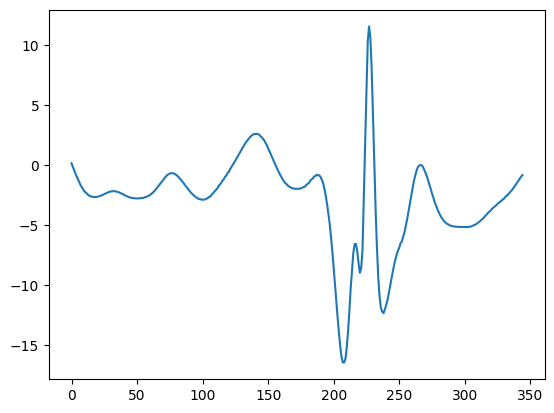

In [21]:
pitch_elbow_moments_df['elbow_moment_x'].plot()

$\textbf{Sandbox}$

In [72]:
import matplotlib.pyplot as plt

In [109]:
# load test JRA file
    # NOTE: filtering reduces amplitude 
test_jra = pd.read_csv('2609_01_JointReaction_ReactionLoads.sto', delim_whitespace=True, skiprows=11)
test_jra_elbow = test_jra[['elbow_r_on_ulna_r_in_ulna_r_mx', 'elbow_r_on_ulna_r_in_ulna_r_my', 'elbow_r_on_ulna_r_in_ulna_r_mz']].values.T

# define rotation matrix
orientation = np.array([-0.0228627, 0.228018, 0.0051688999999999997])
R = id.convert_euler(orientation, 'Z')

# rotate test JRA elbow moments
test_jra_elbow_rotated = R @ test_jra_elbow

$\textbf{Close AWS Connection}$

In [11]:
aws_connection.close()

[AWS]: Database connection closed.
[AWS]: SSH tunnel stopped.
